# Hybrid Collaboritve and Content Based Neurel Network Recommender System

## Import Packages and Data

In [1]:
#for data wrangling
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS

## for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

##for deep learning
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Reshape, Dot
from tensorflow.keras.models import Model


2023-07-20 22:59:46.239595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 22:59:46.348983: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [6]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags_filtered_200.csv')
print(tags.shape)
tags.head()

(492004, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,260,sci-fi,1442169410
2,14,318,imdb top 250,1442615195
3,14,318,justice,1442615192
4,14,1682,philosophy,1442615158


In [7]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings = ratings.drop('timestamp',axis=1)
print(ratings.shape)
ratings.head()

(100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Exploratory Data Analysis

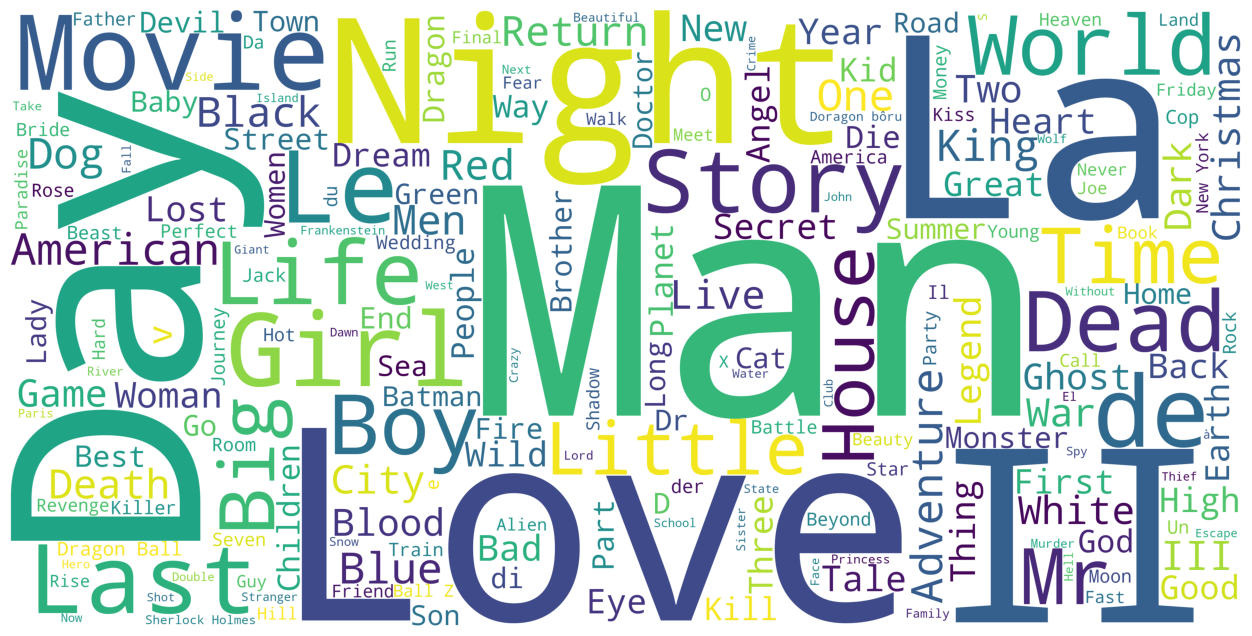

In [42]:
# Create a wordcloud of the movie titles
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

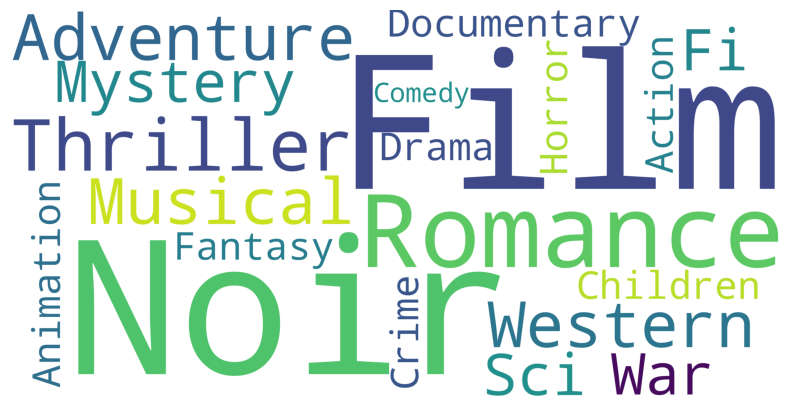

In [41]:
# Collect unique genres using a set
unique_genres = list({genre for genre_list in movies['genres'] for genre in genre_list})
unique_genres.remove('(no genres listed)')

# Create a word cloud of the genres
genre_corpus = ' '.join(unique_genres[1:])
genre_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(genre_corpus)

# Plot the wordcloud
plt.figure(figsize=(10,6))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

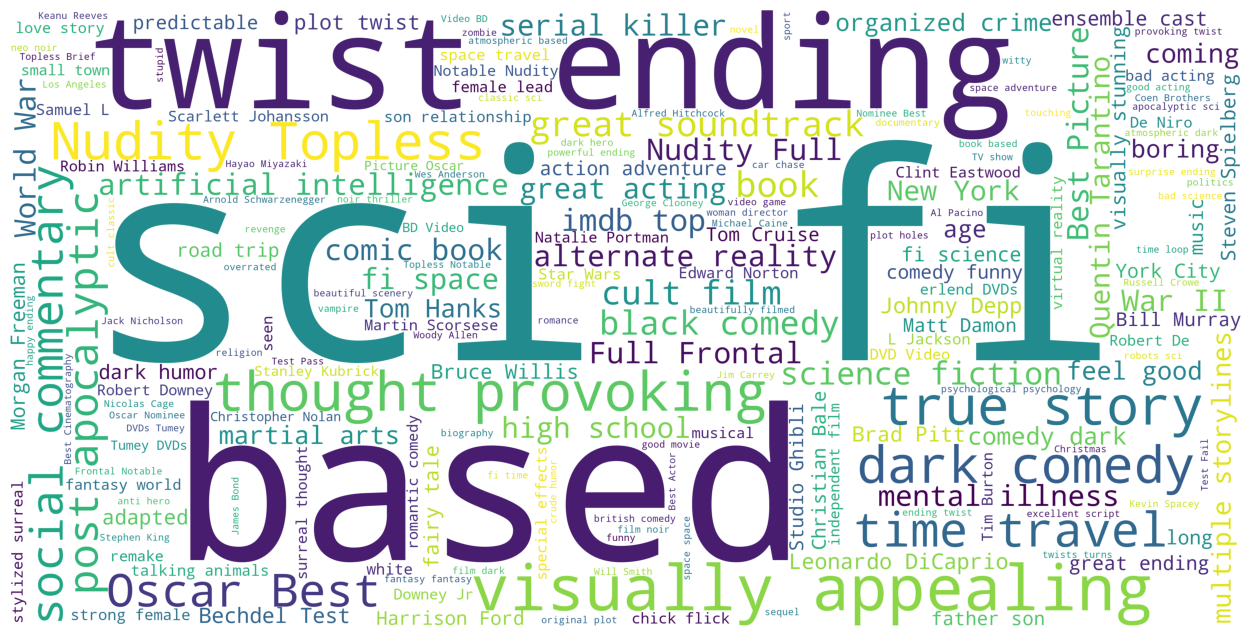

In [15]:
# Create a wordcloud of the tags titles
tag_corpus = ' '.join(tags['tag'])
tag_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(tag_corpus)

# Plot the wordcloud
plt.figure(figsize=(20,8))
plt.imshow(tag_wordcloud)
plt.axis('off')
plt.show()

In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [8]:
average_ratings_per_user = ratings.groupby('userId').size().mean()
print("Average number of ratings per user: {:.2f}".format(average_ratings_per_user))

Average number of ratings per user: 165.30


In [9]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

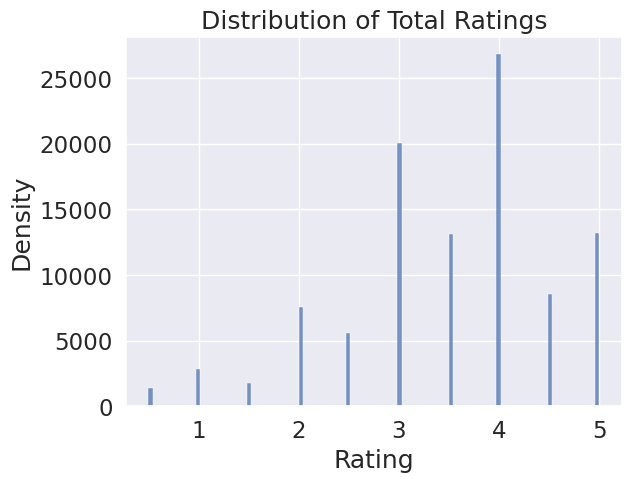

In [10]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.histplot(ratings['rating'].fillna(ratings['rating'].median()))

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution of Total Ratings')

plt.show()

## Data Cleaning and Preprocessing

In [8]:
# Normalize the ratings between 0 and 1
max_rating = ratings['rating'].max()
min_rating = ratings['rating'].min()
print('Maximum Rating:', max_rating)
print('Minimum Rating:', min_rating)

ratings['rating'] = (ratings['rating'] - min_rating) / (max_rating - min_rating)
ratings.head()

Maximum Rating: 5.0
Minimum Rating: 0.5


,userId,movieId,rating
0,1,1,0.777778
1,1,3,0.777778
2,1,6,0.777778
3,1,47,1.000000
4,1,50,1.000000


In [9]:
movies = movies[movies['movieId'].isin(tags['movieId'])]
movies = movies.reset_index(drop=True)

ratings = ratings[ratings['movieId'].isin(tags['movieId'])]
ratings = ratings.reset_index(drop=True)

In [10]:
print(f"There are: {ratings['userId'].nunique()} unqiue users")
print(f"There are: {ratings['movieId'].nunique()} unqiue films in the ratings dataframe")
print(f"There are: {movies['movieId'].nunique()} unqiue films in the movies dataframe")
print(f"There are: {tags['movieId'].nunique()} unqiue films in the tags dataframe")


There are: 610 unqiue users
There are: 9186 unqiue films in the ratings dataframe
There are: 9186 unqiue films in the movies dataframe
There are: 9186 unqiue films in the tags dataframe


### Tag Data Cleaning

In [8]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags.csv')
print(tags.shape)
tags = tags.dropna()
tags.head()

(1108997, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [9]:
print("Unique Users:", tags['userId'].nunique())
print("\nUnique Tags:", tags['tag'].nunique())
print("\nNo. of NaN Values:\n", tags.isna().sum())

Unique Users: 19325

Unique Tags: 74714

No. of NaN Values:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [10]:
tags = tags[tags['movieId'].isin(movies['movieId'])]
tags = tags.reset_index(drop=True)
print(tags.shape)
tags.head()

(869911, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [11]:
print("Unique Users:", tags['userId'].nunique())
print("\nUnique Tags:", tags['tag'].nunique())
print("\nNo. of NaN Values:\n", tags.isna().sum())

Unique Users: 18448

Unique Tags: 54600

No. of NaN Values:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [124]:
#remove tags that occur less than 200 times from the tags dataframe
from collections import Counter

#get values for every tag and count the occurances
all_tags = tags['tag'].values
tag_counts = Counter(all_tags)

# Sort the tags by their frequencies in descending order 
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted tags(its a very long output)
# for tag, count in sorted_tags:
#     print(tag, count)

# Create a list of tags to remove (occurring less than 200 times)
no_of_tag_occurances = 200
tags_to_remove = [tag for tag, count in tag_counts.items() if count < no_of_tag_occurances]
print(len(tags_to_remove), "tags to be removed from dataframe")

#iterate through tags dataframe and find the index numbers of rows to be removed
index_to_remove = []
for num, tag in enumerate(tags['tag']):
    if tag in tags_to_remove:
        index_to_remove.append(num)
        
tags = tags.drop(index_to_remove)
tags = tags.reset_index(drop=True)
print(tags.shape)
tags.head()



215 tags to be removed from dataframe
(492004, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,260,sci-fi,1442169410
2,14,318,imdb top 250,1442615195
3,14,318,justice,1442615192
4,14,1682,philosophy,1442615158


In [125]:
print("Unique Tags:", tags['tag'].nunique())
print("\nNo. of NaN Values:\n", tags.isna().sum())

Unique Tags: 733

No. of NaN Values:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [126]:
tags.to_csv('../data/ml-latest/tags_filtered_200.csv', index=False)

## Bring Data Together

In [11]:
#aggregate tags into list by movie id and merge with movies dataframe
tags_agg = tags.groupby('movieId')['tag'].agg(list)
movies_tag_df = pd.merge(movies, tags_agg, how='inner', on='movieId')

#eliminate duplicate tags in tag lists by turning into a set and then back into a list
movies_tag_df['tag'] = movies_tag_df['tag'].apply(lambda tags: list({tag for tag in tags}))

#display dataframe
print(movies_tag_df.shape)
movies_tag_df.head()

(9186, 4)


,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, funny, feel-good, itaege, sci-fi, f..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[Robin Williams, childish, fantasy, itaege, Fa..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[funny, NO_FA_GANES, CLV, sequel, duringcredit..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[chick flick, characters, based on novel or bo..."
4,5,Father of the Bride Part II (1995),[Comedy],"[Fantasy, wedding, Comedy, remake, parent chil..."


In [12]:
longest_tag = max(movies_tag_df['tag'], key=len)
len(longest_tag)

147

In [13]:
# Extract the genre information
genres = movies_tag_df['genres'].values

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genres)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded genre features
genre_df = pd.DataFrame(genre_features, columns=genre_classes)
print(genre_df.shape)
genre_df.head()

(9186, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


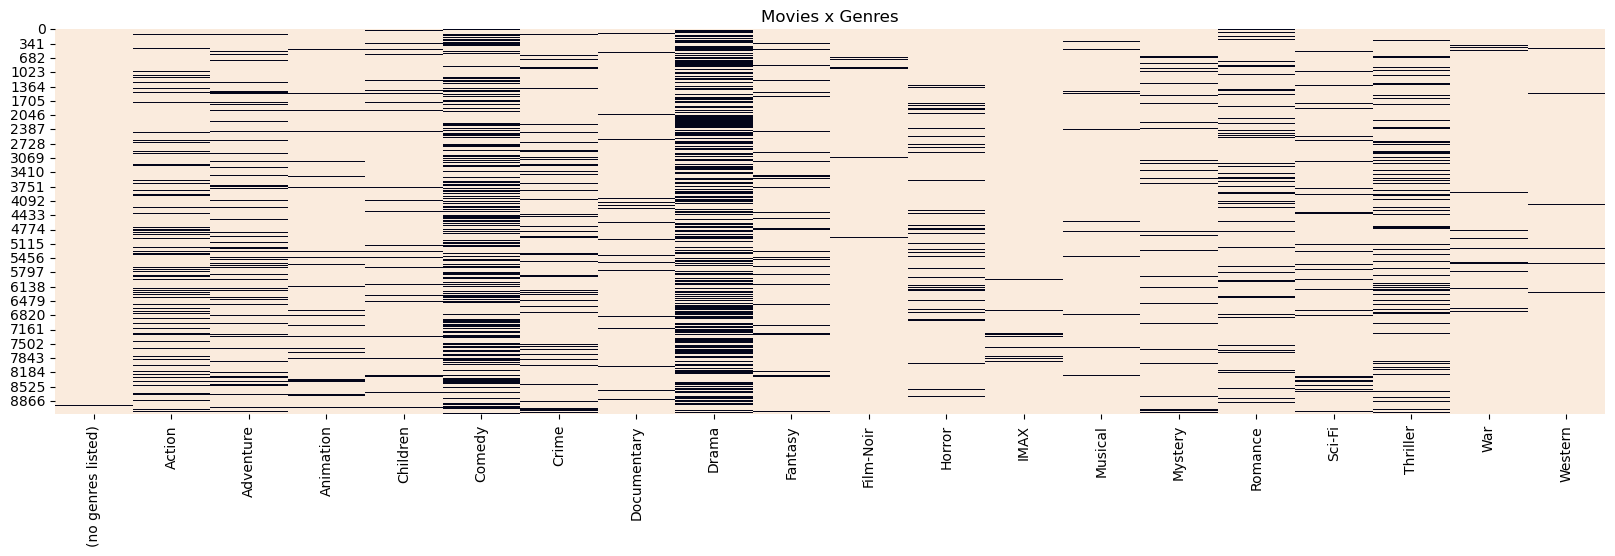

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(genre_df==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Movies x Genres")
plt.show()

In [15]:
# Extract the tag information
tags = movies_tag_df['tag'].values

# Perform one-hot encoding on the tag lists
mlb = MultiLabelBinarizer()
tag_features = mlb.fit_transform(tags)

# Retrieve the list of tag classes
tag_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded tag features
tag_df = pd.DataFrame(tag_features, columns=tag_classes)
print(tag_df.shape)
tag_df.head()

(9186, 733)


,007,1930s,1950s,1960s,1970s,1980s,19th century,70mm,AFI 100,Action,...,whimsical,wilderness,witch,witty,wizards,woman director,women,writers,zombie,zombies
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


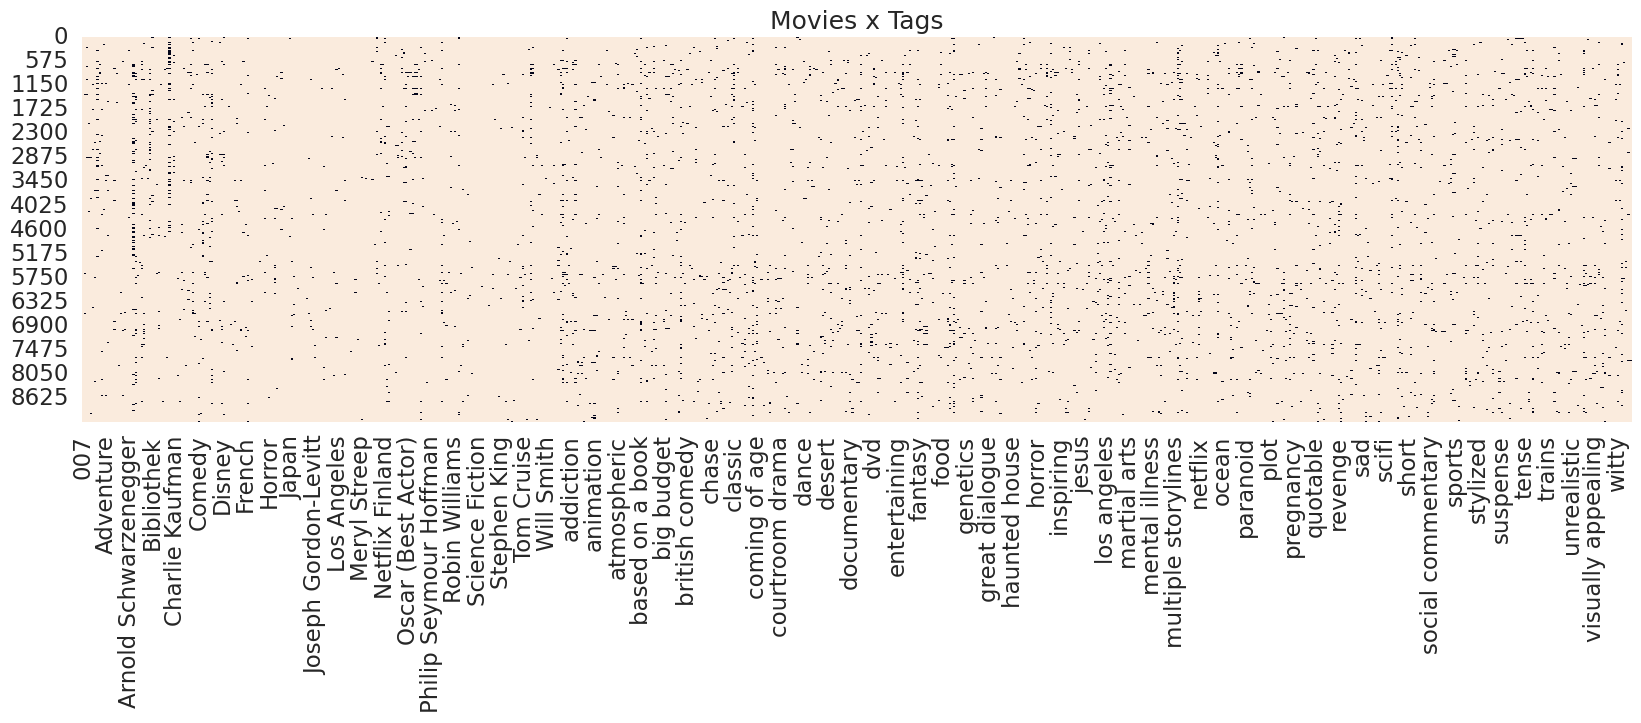

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(tag_df==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Movies x Tags")
plt.show()

In [16]:
movies_features = pd.concat([movies_tag_df,genre_df,tag_df],axis=1)
print(movies_features.shape)
movies_features.head()

(9186, 757)


,movieId,title,genres,tag,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,whimsical,wilderness,witch,witty,wizards,woman director,women,writers,zombie,zombies
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, funny, feel-good, itaege, sci-fi, f...",0,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[Robin Williams, childish, fantasy, itaege, Fa...",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[funny, NO_FA_GANES, CLV, sequel, duringcredit...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[chick flick, characters, based on novel or bo...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],"[Fantasy, wedding, Comedy, remake, parent chil...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
movielens_df = pd.merge(ratings,movies_features,how='left', on = 'movieId')
movielens_df = movielens_df.drop(['title','genres','tag'],axis=1)
print(movielens_df.shape)
movielens_df.head()

(100009, 756)


,userId,movieId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,whimsical,wilderness,witch,witty,wizards,woman director,women,writers,zombie,zombies
0,1,1,0.777778,0,0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,3,0.777778,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,0.777778,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,47,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,50,1.000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Hybrid Filtering with Users, Ratings, Genres and Tags

In [18]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = ratings['userId'].max()
max_movie_id = ratings['movieId'].max()

# Determine the number of genre and tag features
genre_len = len(genre_df.columns)
tag_len = len(tag_df.columns)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_genres = train_data.iloc[:, 3:23].values
train_tags = train_data.iloc[:, 23:].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_genres = test_data.iloc[:, 3:23].values
test_tags = test_data.iloc[:, 23:].values
test_ratings = test_data['rating'].values

In [19]:
def create_hybrid_model(max_user_id, max_movie_id, genre_len, tag_len, embedding_size):
    # Input Layers
    user_input = Input(name='user_input', shape=(1,))
    movie_input = Input(name='movie_input', shape=(1,))
    genre_input = Input(name="genre_input", shape=(genre_len,))
    tag_input = Input(name="tag_input", shape=(tag_len,))
    
    # Collaborative Filtering
    cf_user_embedding = Embedding(name='cf_user_embedding', input_dim=max_user_id+1, output_dim=embedding_size)(user_input)
    cf_user_reshape = Reshape(name='cf_user_reshape', target_shape=(embedding_size,))(cf_user_embedding)
    cf_movie_embedding = Embedding(name='cf_movie_embedding', input_dim=max_movie_id+1, output_dim=embedding_size)(movie_input)
    cf_movie_reshape = Reshape(name='cf_movie_reshape', target_shape=(embedding_size,))(cf_movie_embedding)
    cf_user_movie_dot = Dot(name='cf_user_movie_dot', normalize=True, axes=1)([cf_user_reshape, cf_movie_reshape])

    # Neural Network
    nn_user_embedding = Embedding(name='nn_user_embedding', input_dim=max_user_id+1, output_dim=embedding_size)(user_input)
    nn_user_reshape = Reshape(name='nn_user_reshape', target_shape=(embedding_size,))(nn_user_embedding)
    nn_movie_embedding = Embedding(name='nn_movie_embedding', input_dim=max_movie_id+1, output_dim=embedding_size)(movie_input)
    nn_movie_reshape = Reshape(name='nn_movie_reshape', target_shape=(embedding_size,))(nn_movie_embedding)
    nn_concat = Concatenate()([nn_user_reshape, nn_movie_reshape])
    nn_dense = Dense(name="nn_dense", units=int(embedding_size/2), activation='relu')(nn_concat)

    # Genre Features
    genre_features = Dense(name="genre_features", units=genre_len, activation='relu')(genre_input)

    # Tag Features
    tag_features = Dense(name="tag_features", units=tag_len, activation='relu')(tag_input)

    # Merge all
    pred_ratings = Concatenate()([cf_user_movie_dot, nn_dense, genre_features, tag_features])
    pred_ratings = Dense(name="pred_ratings", units=1, activation='linear')(pred_ratings)

    # Create and compile the model
    model = Model(inputs=[user_input, movie_input, genre_input, tag_input], outputs=pred_ratings, name="hybrid_model")
    model.compile(loss='mse', optimizer='adam')

    return model

In [20]:
# Define the embedding sizes
embedding_size = 50

# Create the hybrid model
hybrid_model = create_hybrid_model(max_user_id, max_movie_id, genre_len, tag_len, embedding_size)

#training inputs
epochs = 5
batch_size = 32

# Train the model
hybrid_model.fit([train_user_ids, train_movie_ids, train_genres, train_tags], train_ratings, epochs = epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)

2023-07-20 23:03:52.640398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
1751/1751 [==============================] - 112s 63ms/step - loss: 0.0452 - val_loss: 0.0384
Epoch 2/5
1751/1751 [==============================] - 110s 63ms/step - loss: 0.0313 - val_loss: 0.0399
Epoch 3/5
1751/1751 [==============================] - 109s 62ms/step - loss: 0.0159 - val_loss: 0.0415
Epoch 4/5
1751/1751 [==============================] - 111s 63ms/step - loss: 0.0097 - val_loss: 0.0433
Epoch 5/5
1751/1751 [==============================] - 108s 62ms/step - loss: 0.0079 - val_loss: 0.0443


In [29]:
hybrid_model.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 nn_user_embedding (Embedding)  (None, 1, 50)        30550       ['user_input[0][0]']             
                                                                                                  
 nn_movie_embedding (Embedding)  (None, 1, 50)       9678300     ['movie_input[0][0]']            
                                                                                       

In [28]:
# import pickle

# # Save the model as a pickle file
# with open('hybrid_model.pkl', 'wb') as file:
#     pickle.dump(hybrid_model, file)

In [21]:
predictions = hybrid_model.predict([test_user_ids, test_movie_ids, test_genres, test_tags])
print("the highest rating the model predicted is:", np.max(predictions))
rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
print('RMSE:', rmse)

626/626 [==============================] - 1s 1ms/step
the highest rating the model predicted is: 1.2320029
RMSE: 0.21049638537066354


In [22]:
predictions = np.clip(predictions, a_min=0, a_max=1.0)
print("the highest rating the model predicted is:", np.max(predictions))
rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
print('RMSE:', rmse)

the highest rating the model predicted is: 1.0
RMSE: 0.2100367083325994


## Tune Model for Better Performance

In [ ]:
# # Define model inputs for hyperparameters tuning
# param_grid = {
#     'max_user_id': [max_user_id],
#     'max_movie_id': [max_movie_id],
#     'genre_len': [genre_len],
#     'tag_len': [tag_len],
#     'embedding_size': [50, 100],
# }

# # Manually set a list of values for epochs and batch_size
# epochs_list = [5, 10, 20]
# batch_size_list = [32, 64, 128, 256]

# best_score = None
# best_params = {}

# # Nested loops for hyperparameter tuning
# for embedding_size in param_grid['embedding_size']:
#     for batch_size in batch_size_list:
#         for epochs in epochs_list:
#             # Create the hybrid model
#             hybrid_model = create_hybrid_model(max_user_id, max_movie_id, genre_len, tag_len, embedding_size)

#             # Train the model
#             hybrid_model.fit([train_user_ids, train_movie_ids, train_genres, train_tags], train_ratings, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)

#             # Evaluate the model performance
#             mse_score = -hybrid_model.evaluate([train_user_ids, train_movie_ids, train_genres, train_tags], train_ratings)

#             # Keep track of the best hyperparameters based on MSE score
#             if best_score is None or mse_score < best_score:
#                 best_score = mse_score
#                 best_params = {
#                     'embedding_size': embedding_size,
#                     'batch_size': batch_size,
#                     'epochs': epochs,
#                 }

# print("Best Hyperparameters:", best_params)
# print("Best Model Score (MSE):", best_score)

## Movie Recommendations!

In [25]:
#recommend the top "n" most recommended films for the test_user
n = 3
test_user = 222

#get all the values of the movie Ids
movie_ids = movies_features['movieId'].values
movie_genres = genre_df.values
movie_tags = tag_df.values

# get a list of movies that user has already seen
user_seen_movies = movielens_df[movielens_df['userId'] == test_user]['movieId'].values

# Get predictions for all movies for the selected user
user_predictions = hybrid_model.predict([np.array([test_user] * len(movie_ids)), movie_ids, movie_genres, movie_tags])

# Unnormalize the ratings
user_predictions = user_predictions * (max_rating - min_rating) + min_rating

# Sort the predictions in descending order
top_movie_indices = user_predictions.argsort(axis=0)[::-1]

#Clip ratings so ratings above 5.0 are 5 star ratings
user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# Filter out the movies that the user has already seen from the recommendations
# Limit the recommendations to the top "n" unseen movies
top_unseen_movie_indices = [index for index in top_movie_indices if movie_ids[index] not in user_seen_movies]
top_unseen_movie_indices = top_unseen_movie_indices[:n]

# Retrieve the movie IDs of the top "n" movies
print(f"Top {n} Recommended Films for User", test_user)
for index in top_unseen_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

288/288 [==============================] - 0s 1ms/step
Top 3 Recommended Films for User 222
Movie: Persepolis (2007) | Predicted Rating: 4.8245025
Movie: Knocked Up (2007) | Predicted Rating: 4.6990933
Movie: Office Space (1999) | Predicted Rating: 4.6262383


In [26]:
#create a data frame of all the films the user has rated and append a column with the predicted rating from the model 

#create user_ratings dataframe
user_ratings = movielens_df[movielens_df['userId'] == test_user][['userId', 'movieId', 'rating']]
user_ratings['rating'] = user_ratings['rating'] * (max_rating - min_rating) + min_rating
user_ratings = pd.merge(user_ratings, movies,on = 'movieId', how='left')
user_films_viewed = user_ratings['movieId'].values

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

#create a array of all the genres & tags from the movies that the user watched
user_movie_features = movies_features[movies_features['movieId'].isin(user_ratings['movieId'])]
user_movie_genres = user_movie_features.iloc[:, 4:24].values
user_movie_tags = user_movie_features.iloc[:, 24:].values


# Get the model predictions for the user and movie IDs
user_predictions = hybrid_model.predict([user_id_array, user_films_viewed, user_movie_genres, user_movie_tags])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
user_predictions = np.clip(user_predictions, a_min=0, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False).head(20)

8/8 [==============================] - 0s 2ms/step


,userId,movieId,rating,title,genres,predicted_rating
245,222,106782,5.0,"Wolf of Wall Street, The (2013)","[Comedy, Crime, Drama]",3.090547
45,222,1220,5.0,"Blues Brothers, The (1980)","[Action, Comedy, Musical]",4.192160
195,222,70565,4.5,"Goods: Live Hard, Sell Hard, The (2009)",[Comedy],2.754536
99,222,3578,4.5,Gladiator (2000),"[Action, Adventure, Drama]",4.337401
204,222,81932,4.5,"Fighter, The (2010)",[Drama],4.482975
53,222,1270,4.5,Back to the Future (1985),"[Adventure, Comedy, Sci-Fi]",4.012081
194,222,69122,4.5,"Hangover, The (2009)","[Comedy, Crime]",4.059292
191,222,68157,4.5,Inglourious Basterds (2009),"[Action, Drama, War]",4.708544
214,222,91529,4.5,"Dark Knight Rises, The (2012)","[Action, Adventure, Crime, IMAX]",4.711307
32,222,858,4.5,"Godfather, The (1972)","[Crime, Drama]",4.147133
